<a href="https://colab.research.google.com/github/subha9542/Datamining/blob/master/Info_miners_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing required libraries and defining Utility functions:

In [1]:
# Importing library 
import math 
import random 
import csv 
import numpy as np
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
from random import seed
from random import randrange
from csv import reader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split 
from sklearn import datasets
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from google.colab import files
import matplotlib.pyplot as plt

filename = 'diabetes_2.csv'

In [2]:
result = []

#utility functions
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Oranges):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[1])
    plt.xticks(tick_marks, rotation=45)
    ax = plt.gca()
    ax.set_xticklabels((ax.get_xticks() +1).astype(str))
    plt.yticks(tick_marks)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def get_classification_report(y_test, y_pred):
    report = classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).iloc[:,:2]
    return df_classification_report

## Algorithms from scratch

### Decision Tree Algorithm

In [3]:
def implement_decision_tree():
		# Load a CSV file
		def load_csv(filename):
			file = open(filename, "rt")
			lines = reader(file)
			dataset = list(lines)
			return dataset
		
		# Split a dataset into k folds
		def cross_validation_split(dataset, n_folds):
			dataset_split = list()
			dataset_copy = list(dataset)
			fold_size = int(len(dataset) / n_folds)
			for i in range(n_folds):
				fold = list()
				while len(fold) < fold_size:
					index = randrange(len(dataset_copy))
					fold.append(dataset_copy.pop(index))
				dataset_split.append(fold)
			return dataset_split
		
		# Calculate accuracy percentage
		def accuracy_metric(actual, predicted):
			correct = 0
			for i in range(len(actual)):
				if actual[i] == predicted[i]:
					correct += 1
			return correct / float(len(actual)) * 100.0
		
		# Evaluate an algorithm using a cross validation split
		def evaluate_algorithm(dataset, algorithm, n_folds, *args):
			folds = cross_validation_split(dataset, n_folds)
			scores = list()
			for fold in folds:
				train_set = list(folds)
				train_set.remove(fold)
				train_set = sum(train_set, [])
				test_set = list()
				for row in fold:
					row_copy = list(row)
					test_set.append(row_copy)
					row_copy[-1] = None
				predicted = algorithm(train_set, test_set, *args)
				actual = [row[-1] for row in fold]
				accuracy = accuracy_metric(actual, predicted)
				scores.append(accuracy)
			return scores,predicted,actual
		
		# Split a dataset based on an attribute and an attribute value
		def test_split(index, value, dataset):
			left, right = list(), list()
			for row in dataset:
				if row[index] < value:
					left.append(row)
				else:
					right.append(row)
			return left, right
		
		# Calculate the Gini index for a split dataset
		def gini_index(groups, classes):
			# count all samples at split point
			n_instances = float(sum([len(group) for group in groups]))
			# sum weighted Gini index for each group
			gini = 0.0
			for group in groups:
				size = float(len(group))
				# avoid divide by zero
				if size == 0:
					continue
				score = 0.0
				# score the group based on the score for each class
				for class_val in classes:
					p = [row[-1] for row in group].count(class_val) / size
					score += p * p
				# weight the group score by its relative size
				gini += (1.0 - score) * (size / n_instances)
			return gini
		
		# Select the best split point for a dataset
		def get_split(dataset):
			class_values = list(set(row[-1] for row in dataset))
			b_index, b_value, b_score, b_groups = 999, 999, 999, None
			for index in range(len(dataset[0])-1):
				for row in dataset:
					groups = test_split(index, row[index], dataset)
					gini = gini_index(groups, class_values)
					if gini < b_score:
						b_index, b_value, b_score, b_groups = index, row[index], gini, groups
			return {'index':b_index, 'value':b_value, 'groups':b_groups}
		
		# Create a terminal node value
		def to_terminal(group):
			outcomes = [row[-1] for row in group]
			return max(set(outcomes), key=outcomes.count)
		
		# Create child splits for a node or make terminal
		def split(node, max_depth, min_size, depth):
			left, right = node['groups']
			del(node['groups'])
			# check for a no split
			if not left or not right:
				node['left'] = node['right'] = to_terminal(left + right)
				return
			# check for max depth
			if depth >= max_depth:
				node['left'], node['right'] = to_terminal(left), to_terminal(right)
				return
			# process left child
			if len(left) <= min_size:
				node['left'] = to_terminal(left)
			else:
				node['left'] = get_split(left)
				split(node['left'], max_depth, min_size, depth+1)
			# process right child
			if len(right) <= min_size:
				node['right'] = to_terminal(right)
			else:
				node['right'] = get_split(right)
				split(node['right'], max_depth, min_size, depth+1)
		
		# Build a decision tree
		def build_tree(train, max_depth, min_size):
			root = get_split(train)
			split(root, max_depth, min_size, 1)
			return root
		
		# Make a prediction with a decision tree
		def predict(node, row):
			if row[node['index']] < node['value']:
				if isinstance(node['left'], dict):
					return predict(node['left'], row)
				else:
					return node['left']
			else:
				if isinstance(node['right'], dict):
					return predict(node['right'], row)
				else:
					return node['right']
		
		# Classification and Regression Tree Algorithm
		def decision_tree(train, test, max_depth, min_size):
			tree = build_tree(train, max_depth, min_size)
			predictions = list()
			for row in test:
				prediction = predict(tree, row)
				predictions.append(prediction)
			return(predictions)
		

		# evaluate algorithm
		#def implement_decision_tree():
		seed(1)
		dataset = load_csv(filename)
		n_folds = 5
		max_depth = 5
		min_size = 10
		scores,predictions ,test_label = evaluate_algorithm(dataset, decision_tree, n_folds, max_depth, min_size)
		print('Scores: %s' % scores)
		accuracy=sum(scores)/float(len(scores))
		result.append(accuracy)
		print('Mean Accuracy: %.3f%%' % (accuracy))

		cm = confusion_matrix(test_label, predictions)
		np.set_printoptions(precision=1) 
		fig, ax = plt.subplots()
		plot_confusion_matrix(cm)
		plt.show()
		#classification report
		print("\nClassification Report:\n")
		print(get_classification_report(test_label, predictions))

### Naive Bayes




In [4]:
def implement_naive_bayes():
    def encode_class(mydata): 
        classes = [] 
        for i in range(len(mydata)): 
            if mydata[i][-1] not in classes: 
                classes.append(mydata[i][-1]) 
        for i in range(len(classes)): 
            for j in range(len(mydata)): 
                if mydata[j][-1] == classes[i]: 
                    mydata[j][-1] = i 
        return mydata             
                  
      
    # Splitting the data 
    def splitting(mydata, ratio): 
        train_num = int(len(mydata) * ratio) 
        train = [] 
        # initally testset will have all the dataset  
        test = list(mydata) 
        while len(train) < train_num: 
            # index generated randomly from range 0  
            # to length of testset 
            index = random.randrange(len(test)) 
            # from testset, pop data rows and put it in train 
            train.append(test.pop(index)) 
        return train, test 
      
      
    # Group the data rows under each class yes or  
    # no in dictionary eg: dict[yes] and dict[no]  
    def groupUnderClass(mydata): 
          dict = {} 
          for i in range(len(mydata)): 
              if (mydata[i][-1] not in dict): 
                  dict[mydata[i][-1]] = [] 
              dict[mydata[i][-1]].append(mydata[i]) 
          return dict
      
      
    # Calculating Mean 
    def mean(numbers): 
        return sum(numbers) / float(len(numbers)) 
      
    # Calculating Standard Deviation 
    def std_dev(numbers): 
        avg = mean(numbers) 
        variance = sum([pow(x - avg, 2) for x in numbers]) / float(len(numbers) - 1) 
        return math.sqrt(variance) 
      
    def MeanAndStdDev(mydata): 
        info = [(mean(attribute), std_dev(attribute)) for attribute in zip(*mydata)] 
        del info[-1] 
        return info 
      
    # find Mean and Standard Deviation under each class 
    def MeanAndStdDevForClass(mydata): 
        info = {} 
        dict = groupUnderClass(mydata) 
        for classValue, instances in dict.items(): 
            info[classValue] = MeanAndStdDev(instances) 
        return info 
      
      
    # Calculate Gaussian Probability Density Function 
    def calculateGaussianProbability(x, mean, stdev): 
        expo = math.exp(-(math.pow(x - mean, 2) / (2 * math.pow(stdev, 2)))) 
        return (1 / (math.sqrt(2 * math.pi) * stdev)) * expo 
      
      
    # Calculate Class Probabilities 
    def calculateClassProbabilities(info, test): 
        probabilities = {} 
        for classValue, classSummaries in info.items(): 
            probabilities[classValue] = 1
            for i in range(len(classSummaries)): 
                mean, std_dev = classSummaries[i] 
                x = test[i] 
                probabilities[classValue] *= calculateGaussianProbability(x, mean, std_dev) 
        return probabilities 
      
      
    # Make prediction - highest probability is the prediction 
    def predict(info, test): 
        probabilities = calculateClassProbabilities(info, test) 
        bestLabel, bestProb = None, -1
        for classValue, probability in probabilities.items(): 
            if bestLabel is None or probability > bestProb: 
                bestProb = probability 
                bestLabel = classValue 
        return bestLabel 
      
      
    # returns predictions for a set of examples 
    def getPredictions(info, test): 
        predictions = [] 
        for i in range(len(test)): 
            result = predict(info, test[i]) 
            predictions.append(result) 
        return predictions 
      
    # Accuracy score 
    def accuracy_rate(test, predictions): 
        correct = 0
        for i in range(len(test)): 
            if test[i][-1] == predictions[i]: 
                correct += 1
        return (correct / float(len(test))) * 100.0
      

#def implement_naive_bayes():  
    mydata = csv.reader(open(filename, "rt")) 
    mydata = list(mydata) 
    mydata = encode_class(mydata) 
    for i in range(len(mydata)): 
        mydata[i] = [float(x) for x in mydata[i]] 
      
    ratio = 0.7
    train_data, test_data = splitting(mydata, ratio) 
    print('Total number of examples are: ', len(mydata)) 
    print('Out of these, training examples are: ', len(train_data)) 
    print("Test examples are: ", len(test_data)) 
      
    # prepare model 
    info = MeanAndStdDevForClass(train_data) 
      
    # test model 
    predictions = getPredictions(info, test_data) 
    accuracy = accuracy_rate(test_data, predictions) 
    result.append(accuracy)
    print("Accuracy of your model is: ", accuracy)

    test_label=[i[-1] for i in test_data]
    cm = confusion_matrix(test_label, predictions)
    np.set_printoptions(precision=1) 
    # print('Confusion matrix')
    # print(cm)
    fig, ax = plt.subplots()
    plot_confusion_matrix(cm)
    plt.show()

    #classification report
    print("\nClassification Report:\n")
    print(get_classification_report(test_label, predictions))

### Support Vector Machine


In [5]:
def implement_SVM():
    def compute_cost(W, X, Y):
        # calculate hinge loss
        N = X.shape[0]
        distances = 1 - Y * (np.dot(X, W))
        distances[distances < 0] = 0  # equivalent to max(0, distance)
        hinge_loss = regularization_strength * (np.sum(distances) / N)

        # calculate cost
        cost = 1 / 2 * np.dot(W, W) + hinge_loss
        return cost


    def calculate_cost_gradient(W, X_batch, Y_batch):
        if type(Y_batch) == np.float64:
            Y_batch = np.array([Y_batch])
            X_batch = np.array([X_batch])  

        distance = 1 - (Y_batch * np.dot(X_batch, W))
        dw = np.zeros(len(W))

        for ind, d in enumerate(distance):
            if max(0, d) == 0:
                di = W
            else:
                di = W - (regularization_strength * Y_batch[ind] * X_batch[ind])
            dw += di

        dw = dw/len(Y_batch)  
        return dw


    def sgd(features, outputs):
        max_epochs = 5000
        weights = np.zeros(features.shape[1])
        nth = 0
        prev_cost = float("inf")
        cost_threshold = 0.01  
        for epoch in range(1, max_epochs):
            X, Y = shuffle(features, outputs)
            for ind, x in enumerate(X):
                ascent = calculate_cost_gradient(weights, x, Y[ind])
                weights = weights - (learning_rate * ascent)
            if epoch == 2 ** nth or epoch == max_epochs - 1:
                cost = compute_cost(weights, features, outputs)
    #             print("Epoch is: {} and Cost is: {}".format(epoch, cost))
                # stoppage criterion
                if abs(prev_cost - cost) < cost_threshold * prev_cost:
                    return weights
                prev_cost = cost
                nth += 1
        return weights

    # Accuracy score 
    def accuracy_rate(test, predictions): 
        correct = 0
        for i in range(len(test)): 
            if test[i][-1] == predictions[i]: 
                correct += 1
        return (correct / float(len(test))) * 100.0


    def init(dataset):
        Y = dataset.iloc[:,-1:]
        X = dataset.iloc[:,:-1]

        X_normalized = MinMaxScaler().fit_transform(X.values)
        X = pd.DataFrame(X_normalized)

        # insert 1 in every row for intercept b
        X.insert(loc=len(X.columns), column='intercept', value=1)

        X_train, X_test, y_train, y_test = tts(X, Y, test_size=0.3, random_state=1)

        W = sgd(X_train.values, y_train.values)
        y_train_predicted = np.array([])
        for i in range(X_train.shape[0]):
            yp = np.sign(np.dot(X_train.values[i], W))
            y_train_predicted = np.append(y_train_predicted, yp)

        y_test_predicted = np.array([])
        for i in range(X_test.shape[0]):
            yp = np.sign(np.dot(X_test.values[i], W))
            y_test_predicted = np.append(y_test_predicted, yp)
        
        print('Total number of examples are: ', len(dataset)) 
        print('Out of these, training examples are: ', len(X_train)) 
        print("Test examples are: ", len(X_test)) 
        accuracy = accuracy_score(y_test, y_test_predicted) * 100
        result.append(accuracy)
        print("Accuracy of your model is: ", accuracy)

        cm = confusion_matrix(y_test, y_test_predicted)
        np.set_printoptions(precision=1) 
        fig, ax = plt.subplots()
        plot_confusion_matrix(cm)
        plt.show()

        #classification report
        print("\nClassification Report:\n")
        print(get_classification_report(y_test, y_test_predicted))

#def implement_SVM():
    # set hyper-parameters and call init
    regularization_strength = 10000
    learning_rate = 0.000001
    dataset = pd.read_csv(filename)
    init(dataset)

## Algorithms using built-in libraries:

### Naive Bayes using Scikit

In [6]:
def implement_NaiveBayes_scikit():
    dataset=pd.read_csv(filename,header=None)


    X = dataset.loc[:,0:7]
    y =dataset[8]
      
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 

      
    # training the model on training set 
    from sklearn.naive_bayes import GaussianNB 
    gnb = GaussianNB() 
    gnb.fit(X_train, y_train) 
      
    # making predictions on the testing set 
    y_pred = gnb.predict(X_test) 
      
    # comparing actual response values (y_test) with predicted response values (y_pred) 
    from sklearn import metrics 

    print('Total number of examples are: ', len(dataset)) 
    print('Out of these, training examples are: ', len(X_train)) 
    print("Test examples are: ", len(X_test)) 
    accuracy= metrics.accuracy_score(y_test, y_pred)*100
    result.append(accuracy)
    print("Gaussian Naive Bayes model accuracy(in %):",accuracy )

    #confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=1) 
    # print('Confusion matrix')
    # print(cm)
    fig, ax = plt.subplots()
    plot_confusion_matrix(cm)

    plt.show()



    #classification report
    print("\nClassification Report:\n")
    get_classification_report(y_test, y_pred)


### Support Vection machine using Scikit

In [7]:
def implement_SVM_scikit():
    model = SVC(kernel='linear')
    model.fit(X_train, y_train)

    model = SVC(kernel='linear')
    model.fit(X_train, y_train)

    y_pred = gnb.predict(X_test) 
      
    # comparing actual response values (y_test) with predicted response values (y_pred) 


    print('Total number of examples are: ', len(dataset)) 
    print('Out of these, training examples are: ', len(X_train)) 
    print("Test examples are: ", len(X_test))
    accuracy= metrics.accuracy_score(y_test, y_pred)*100
    result.append(accuracy)
    print(" model accuracy(in %):", accuracy)

    #confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=1) 
    # print('Confusion matrix')
    # print(cm)
    fig, ax = plt.subplots()
    plot_confusion_matrix(cm)

    plt.show()


    #classification report
    print("\nClassification Report:\n")
    get_classification_report(y_test, y_pred)

### Decision Tree using Scikit:

In [8]:
def implement_Decision_tree_scikit():
    tree = DecisionTreeClassifier(max_depth=3, random_state=0)
    tree.fit(X_train, y_train)

    # making predictions on the testing set 
    y_pred = tree.predict(X_test) 

    from sklearn import metrics 

    print('Total number of examples are: ', len(dataset)) 
    print('Out of these, training examples are: ', len(X_train)) 
    print("Test examples are: ", len(X_test)) 
    accuracy=metrics.accuracy_score(y_test, y_pred)*100
    result.append(accuracy)
    print("Desicion tree model accuracy(in %):", accuracy)


    #confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=1) 
    # print('Confusion matrix')
    # print(cm)
    fig, ax = plt.subplots()
    plot_confusion_matrix(cm)

    plt.show()

    #classification report
    print("\nClassification Report:\n")
    get_classification_report(y_test, y_pred)

## Comparing Algorithms:

In [9]:
def compare():
    labels =['NB','SVM','DT']
    acc_alg = [result[x] for x in range(len(result)) if x%2==0]
    acc_lib = [result[x] for x in range(len(result)) if x%2!=0]

    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(figsize=(10,7))
    fig.suptitle('Comparison of Algorithm ')
    # plt.figure(figsize=(10,10))
    rects1 = ax.bar(x - width/2, acc_alg, width, label='Algorithm from scratch')
    rects2 = ax.bar(x + width/2, acc_lib, width, label='Algorithm using libraries')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Accuracy Score')
    ax.set_xlabel('Classifiction Algorithms')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc=1)

    plt.show()


# Start Here:

## If using Anaconda
### Please select the algorithm you want to implement from the choice list (input integer):
#### 1. Decision Tree
#### 2. Support Vector Machine
#### 3. Naive Bayes

In [18]:
choice = int(input('Your choice: '))
filename = input('Please input dataset you want to use: ')


Your choice: 2
Please input dataset you want to use: diabetes_2.csv


Total number of examples are:  1999
Out of these, training examples are:  1399
Test examples are:  600
Accuracy of your model is:  34.166666666666664


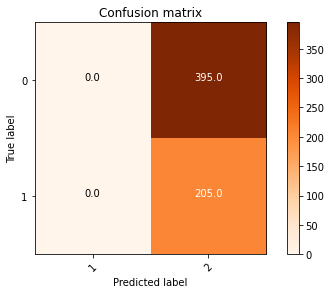


Classification Report:

               0           1
precision    0.0    0.341667
recall       0.0    1.000000
f1-score     0.0    0.509317
support    395.0  205.000000


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
if choice == 1:
    implement_decision_tree()
elif choice == 2:
    implement_SVM()
else:
    implement_naive_bayes()
